# Applied Machine Learning Finance

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cvxopt
import time
import itertools
import joblib

from jsonschema.exceptions import relevance
from courselib.models.linear_models import LinearBinaryClassification, RidgeClassifier, LinearRegression
from courselib.models.nn import Sigmoid
from courselib.models.nn import MLP
from courselib.models.svm import BinaryKernelSVM
from courselib.models.svm import Kernel, RBFKernel, PolynomialKernel,LinearKernel
from courselib.utils.splits import train_test_split
from courselib.models.base import TrainableModel
from courselib.utils.metrics import binary_accuracy, mean_squared_error, mean_absolute_error,accuracy
from courselib.optimizers import GDOptimizer
from courselib.models.linear_models import LinearBinaryClassification, RidgeClassifier
from courselib.utils.normalization import min_max
from courselib.models.glm import LogisticRegression
from courselib.models.base import TrainableModel
from courselib.utils.preprocessing import labels_encoding
from courselib.models.svm import LinearSVM
from courselib.models.svm import BinaryKernelSVM
from courselib.utils.metrics import cross_entropy
from courselib.utils.normalization import standardize
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import mutual_info_classif

## Functions

In [3]:
def fetch_data(ticker='SPY', start='2015-01-01', end='2023-12-31'):
    data = yf.download(ticker, start, end)
    df = pd.DataFrame(data)
    df.columns = df.columns.droplevel(1)
    return df



def compute_technical_indicators(data,amount,window):
    df = data.copy()

    df[f'SMA_{window}'] = df['Close'].rolling(window=window).mean()

    df[f'EMA_{window}'] = df['Close'].ewm(span=window, adjust=False).mean()

    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = delta.clip(upper=0).abs()
    avg_gain = up.ewm(window, adjust=False).mean()
    avg_loss = down.ewm(window, adjust=False).mean()
    rs = avg_gain / avg_loss
    df[f'RSI_{window}'] = 100 - (100 / (1 + rs))

    sma = df['Close'].rolling(window=20).mean()
    std = df['Close'].rolling(window=20).std()
    df['Bollinger_Upper'] = sma + 2 * std
    df['Bollinger_Lower'] = sma - 2 * std

    ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema_12 - ema_26
    df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['Daily_Return'] = df['Close'].pct_change()


    df['Rolling_5d_Std'] = df['Daily_Return'].rolling(window=5).std()

    for i in range(amount):
        df[f'Lag_{i+1}'] = df['Daily_Return'].shift(i)

    # Momentum
    df['Momentum_10'] = df['Close'] - df['Close'].shift(10)
    return df

def return_data(df, target_type='Target_01', train_frac=0.8,features='whole'):
    df['Trend'] = df['Close'].rolling(window=5).mean().shift(-1) > df['Close']
    df['Target_01'] = np.where(df['Trend'], 1, 0)
    df['Target_-1'] = np.where(df['Trend'], 1, -1)
    df = compute_technical_indicators(df, 3, 14)

    whole = ['SMA_14', 'EMA_14', 'RSI_14', 'Bollinger_Upper', 'Bollinger_Lower',
                'MACD', 'MACD_Signal', 'Daily_Return', 'Rolling_5d_Std',
                'Lag_1', 'Lag_2', 'Lag_3', 'Momentum_10', target_type, 'Close']
    
    correlation = ['Lag_2','Momentum_10','RSI_14','Lag_1',target_type,'Daily_Return']
    
    relevance = ['Daily_Return','Lag_1','RSI_14','Momentum_10',target_type,'Lag_2']
    
    lagged = ['Lag_1', 'Lag_2', 'Lag_3', target_type]
    
    if features == 'whole':
        features = whole
    elif features == 'correlation':
        features = correlation
    elif features == 'relevance':
        features = relevance
    elif features == 'lagged':
        features = lagged
    else:
        assert isinstance(features, list), "`features` must be 'whole' or a list of feature names."

    df = df[features]
    df = df.reset_index()
    df.dropna(inplace=True)

    X, Y, X_train, Y_train, X_test, Y_test = train_test_split(df.iloc[:, df.columns != 'Date'],
                                                              training_data_fraction=train_frac,
                                                              return_numpy=True,
                                                              shuffle=False,
                                                              class_column_name=target_type)
    return X, Y, X_train, Y_train, X_test, Y_test



In [4]:
def return_data_daily_return(df, target_type='Target_01', train_frac=0.8,features='whole'):
    df['Target_Sign'] = np.sign(df['Close'].shift(-1) - df['Close']).shift(-1)
    df['Target_Sign_01'] = np.where(df['Target_Sign'] > 0, 1, 0)
    df = compute_technical_indicators(df, 3, 14)

    whole = ['SMA_14', 'EMA_14', 'RSI_14', 'Bollinger_Upper', 'Bollinger_Lower',
                'MACD', 'MACD_Signal', 'Daily_Return', 'Rolling_5d_Std',
                'Lag_1', 'Lag_2', 'Lag_3', 'Momentum_10', target_type, 'Close']
    
    correlation = ['Lag_2','Momentum_10','RSI_14','Lag_1',target_type,'Daily_Return']
    
    relevance = ['Daily_Return','Lag_1','RSI_14','Momentum_10',target_type,'Lag_2']
    
    lagged = ['Lag_1', 'Lag_2', 'Lag_3', target_type]
    
    if features == 'whole':
        features = whole
    elif features == 'correlation':
        features = correlation
    elif features == 'relevance':
        features = relevance
    elif features == 'lagged':
        features = lagged
    else:
        assert isinstance(features, list), "`features` must be 'whole' or a list of feature names."

    df = df[features]
    df = df.reset_index()
    df.dropna(inplace=True)

    X, Y, X_train, Y_train, X_test, Y_test = train_test_split(df.iloc[:, df.columns != 'Date'],
                                                              training_data_fraction=train_frac,
                                                              return_numpy=True,
                                                              shuffle=False,
                                                              class_column_name=target_type)
    return X, Y, X_train, Y_train, X_test, Y_test, df


## Model testing and Analysis


In [5]:
df = fetch_data('SPY', '2015-01-01', '2023-12-31')
df

/var/folders/pz/bkvmpwns7mgcx9s_bqb2lbyc0000gn/T/ipykernel_1982/1762355872.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start, end)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
2015-01-02,171.568039,172.779039,170.524082,172.361456,121465900
2015-01-05,168.469559,170.682742,168.160552,170.515711,169632600
2015-01-06,166.882782,169.304757,166.081017,168.778599,209151400
2015-01-07,168.962326,169.304747,167.768046,168.219029,125346700
2015-01-08,171.960571,172.177722,170.365415,170.382109,147217800
...,...,...,...,...,...
2023-12-22,464.874420,466.572378,462.960567,465.080521,67126600
2023-12-26,466.837341,467.750103,465.208094,465.286628,55387000
2023-12-27,467.681458,467.828672,466.091477,466.631275,68000300


### Logistic Regression

In [7]:
# Prepare data
X, Y, X_train, Y_train, X_test, Y_test = return_data(df, target_type='Target_01', train_frac=0.8, features='whole')
X = min_max(X)
X_train = min_max(X_train)
X_test = min_max(X_test)

# Model setup
w = [0] * X.shape[1]
b = 0
optimizer = GDOptimizer(learning_rate=1e-2)

accuracy_reg = lambda y_true, y_pred: binary_accuracy(y_true, y_pred, class_labels=[0, 1])
metrics_dict = {'accuracy': accuracy_reg, 'MSE': mean_squared_error}

model_regression = LogisticRegression(w, b, optimizer)

# Train the model
metrics_history = model_regression.fit(
    X_train, Y_train,
    num_epochs=20000,
    batch_size=len(X_train),
    compute_metrics=True,
    metrics_dict=metrics_dict
)
joblib.dump((model_regression, metrics_history, X_test, Y_test, X, df), "regression_model_outputs.pkl")

['regression_model_outputs.pkl']

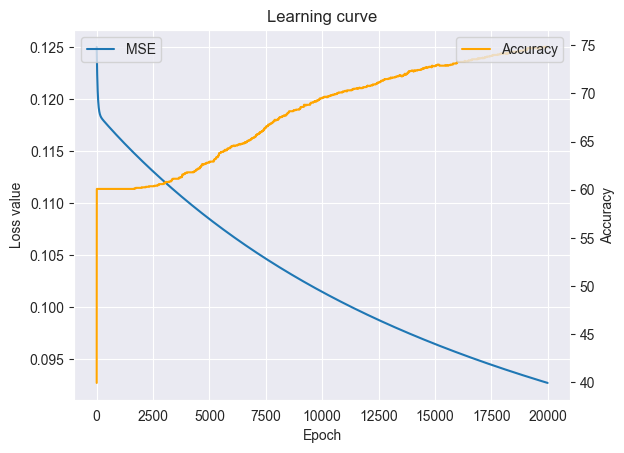

The final train accuracy: 74.83%
Test accuracy: 84.19%


In [8]:
model_regression, metrics_history, X_test, Y_test, X_full, df = joblib.load("regression_model_outputs.pkl")
# Plot learning curve
fig, ax = plt.subplots()
ax.plot(range(len(metrics_history['MSE'])), metrics_history['MSE'], label='MSE')
ax.set_ylabel('Loss value')
ax2 = ax.twinx()
ax2.plot(range(len(metrics_history['accuracy'])), metrics_history['accuracy'], color='orange', label='Accuracy')
ax2.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
plt.title('Learning curve')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.grid()
plt.show()

# Evaluation
print(f'The final train accuracy: {metrics_history["accuracy"][-1]:.2f}%')
print(f'Test accuracy: {accuracy_reg(model_regression.decision_function(X_test), Y_test):.2f}%')

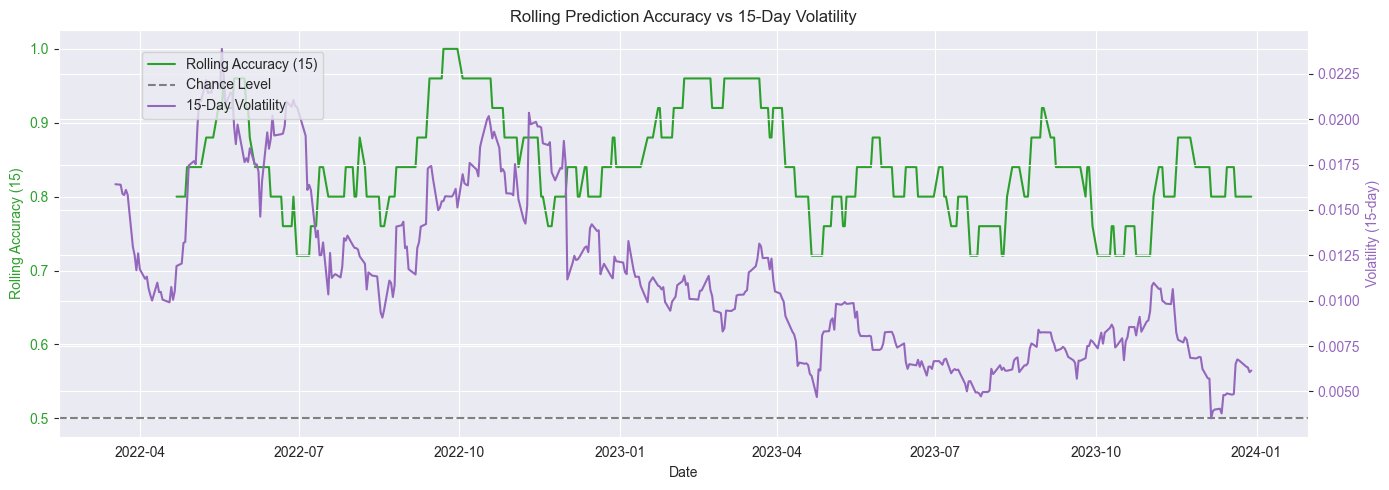

In [9]:
model_regression, metrics_history, X_test, Y_test, X_full, df = joblib.load("regression_model_outputs.pkl")

# Ensure Date column exists
if 'Date' not in df.columns and df.index.name == 'Date':
    df = df.reset_index()

# Prepare indicators and labels
df_copy = df.copy()
df_copy['Trend'] = df_copy['Close'].rolling(window=5).mean().shift(-1) > df_copy['Close']
df_copy['Target_01'] = np.where(df_copy['Trend'], 1, 0)
df_copy['Target_-1'] = np.where(df_copy['Trend'], 1, -1)
df_copy = compute_technical_indicators(df_copy, 3, 14)
df_copy = df_copy.reset_index(drop=True)
df_copy.dropna(inplace=True)

# Align dates with model input
date_series = df_copy['Date'].iloc[-len(X_full):].values
split_idx = int(len(X_full) * 0.8)
test_dates = date_series[split_idx:]

# Model predictions
Y_pred = model_regression(X_test)
Y_pred_labels = (Y_pred > 0.5).astype(int).flatten()
Y_true_labels = Y_test.flatten()

# Accuracy computation
results_df = pd.DataFrame({
    'Date': test_dates,
    'True': Y_true_labels,
    'Predicted': Y_pred_labels
})
results_df['Correct'] = results_df['True'] == results_df['Predicted']
results_df['Rolling_Accuracy'] = results_df['Correct'].rolling(window=25).mean()

# Volatility computation
df_copy['Daily_Return'] = df_copy['Close'].pct_change()
df_copy['Volatility_15d'] = df_copy['Daily_Return'].rolling(window=15).std()
vol_series = df_copy['Volatility_15d'].iloc[-len(X_full):].values
vol_test = vol_series[split_idx:]

# --- Combined Plot ---
fig, ax1 = plt.subplots(figsize=(14, 5))

# Plot Rolling Accuracy
color1 = 'tab:green'
ax1.set_xlabel('Date')
ax1.set_ylabel('Rolling Accuracy (15)', color=color1)
ax1.plot(test_dates, results_df['Rolling_Accuracy'], color=color1, label='Rolling Accuracy (15)')
ax1.axhline(0.5, color='gray', linestyle='--', label='Chance Level')
ax1.tick_params(axis='y', labelcolor=color1)

# Create second y-axis
ax2 = ax1.twinx()
color2 = 'tab:purple'
ax2.set_ylabel('Volatility (15-day)', color=color2)
ax2.plot(test_dates, vol_test, color=color2, label='15-Day Volatility')
ax2.tick_params(axis='y', labelcolor=color2)

# Title and layout
plt.title('Rolling Prediction Accuracy vs 15-Day Volatility')
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

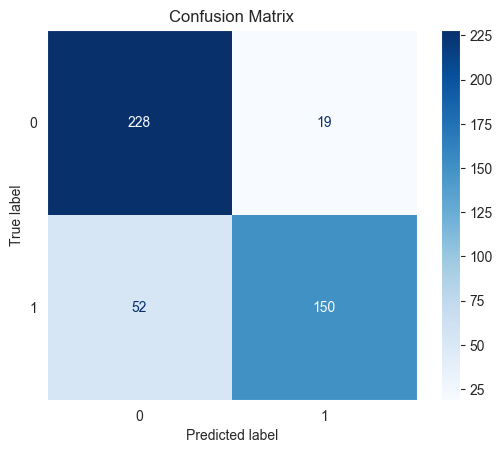

In [10]:
model_regression, metrics_history, X_test, Y_test, X_full, df = joblib.load("regression_model_outputs.pkl")
y_pred = model_regression(X_test)

# Compute confusion matrix
cm = confusion_matrix(Y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()

### Kernel SVM

In [129]:
X, Y, X_train, Y_train, X_test, Y_test= return_data(df,target_type='Target_-1',train_frac=.8,features='whole')
X = min_max(X)
X_train = min_max(X_train)
X_test = min_max(X_test)
kernels = ['linear', 'polynomial', 'rbf']
for i in range(10):
    start = time.time()
    svm_poly = BinaryKernelSVM(kernel='polynomial', degree=i)
    svm_poly.fit(X_train, Y_train)
    end = time.time()

    test_acc = binary_accuracy(svm_poly(X_test), Y_test)

    train_acc = binary_accuracy(svm_poly(X_train), Y_train)

    print(f'Test accuracy degree {i}: {test_acc:.4f}, Train accuracy: {train_acc:.4f}')

    train_time = end - start

    print(f"⏱️ Train time: {train_time:.4f} seconds")

sigma_values = [0.01, 0.05, 0.1, 0.2, 0.5, 1.0]
for i in sigma_values:
    start = time.time()
    svm_rbf = BinaryKernelSVM(kernel='rbf', sigma=i)
    svm_rbf.fit(X_train, Y_train)
    end = time.time()

    test_acc = binary_accuracy(svm_rbf(X_test), Y_test)

    train_acc = binary_accuracy(svm_rbf(X_train), Y_train)

    print(f'Test accuracy sigma {i}: {test_acc:.4f}, Train accuracy: {train_acc:.4f}')

    train_time = end - start

    print(f"⏱️ Train time: {train_time:.4f} seconds")


Test accuracy degree 0: 55.0111, Train accuracy: 60.0780
⏱️ Train time: 5.6063 seconds
Test accuracy degree 1: 68.3742, Train accuracy: 84.1871
⏱️ Train time: 14.4992 seconds
Test accuracy degree 2: 55.9020, Train accuracy: 90.1448
⏱️ Train time: 16.0445 seconds
Test accuracy degree 3: 55.6793, Train accuracy: 91.9265
⏱️ Train time: 16.3004 seconds
Test accuracy degree 4: 54.7884, Train accuracy: 92.6503
⏱️ Train time: 16.1904 seconds
Test accuracy degree 5: 57.9065, Train accuracy: 92.9844
⏱️ Train time: 14.2470 seconds
Test accuracy degree 6: 61.9154, Train accuracy: 94.0980
⏱️ Train time: 15.1669 seconds
Test accuracy degree 7: 66.8151, Train accuracy: 88.0846
⏱️ Train time: 16.1039 seconds
Test accuracy degree 8: 57.6837, Train accuracy: 89.9777
⏱️ Train time: 19.8627 seconds
Test accuracy degree 9: 59.2428, Train accuracy: 91.1470
⏱️ Train time: 23.0408 seconds
Test accuracy sigma 0.01: 55.0111, Train accuracy: 100.0000
⏱️ Train time: 11.0791 seconds
Test accuracy sigma 0.05: 55.0

Test accuracy sigma 1: 74.3875, Train accuracy: 82.9621


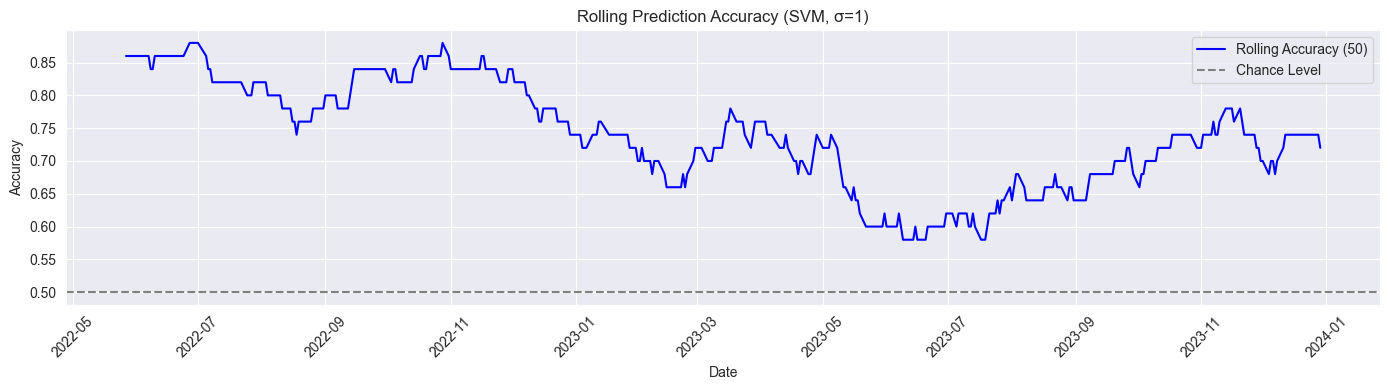

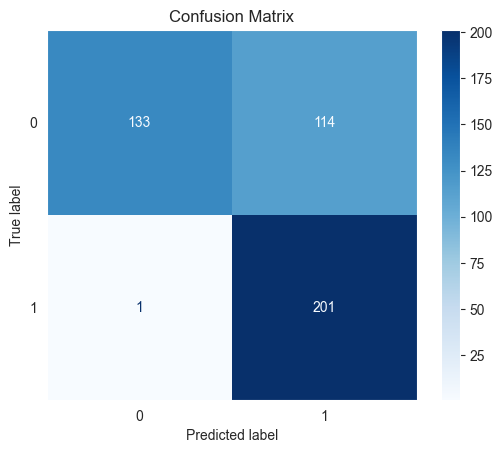

In [11]:
# Prepare data
X, Y, X_train, Y_train, X_test, Y_test = return_data(df, target_type='Target_-1', train_frac=0.8, features='whole')
X_train = min_max(X_train)
X_test = min_max(X_test)
X = min_max(X)

# Train model
svm_rbf = BinaryKernelSVM(kernel='rbf', sigma=1)
svm_rbf.fit(X_train, Y_train)

# Evaluate
test_acc = binary_accuracy(svm_rbf(X_test), Y_test)
train_acc = binary_accuracy(svm_rbf(X_train), Y_train)

print(f'Test accuracy sigma {1}: {test_acc:.4f}, Train accuracy: {train_acc:.4f}')

# --- Rolling accuracy visualization ---

# Get the corresponding dates from the original df
df_copy = df.copy()
df_copy['Trend'] = df_copy['Close'].rolling(window=5).mean().shift(-1) > df_copy['Close']
df_copy['Target_01'] = np.where(df_copy['Trend'], 1, 0)
df_copy['Target_-1'] = np.where(df_copy['Trend'], 1, -1)
df_copy = compute_technical_indicators(df_copy, 3, 14)
df_copy = df_copy.reset_index()  # Ensure 'Date' is a column
df_copy.dropna(inplace=True)

# Align dates with final feature set
date_series = df_copy['Date'].iloc[-len(X):].values
split_idx = int(len(X) * 0.8)
test_dates = date_series[split_idx:]

# Predictions
Y_pred = svm_rbf(X_test)
results_df = pd.DataFrame({
    'Date': test_dates,
    'True': Y_test,
    'Predicted': Y_pred
})
results_df['Correct'] = results_df['True'] == results_df['Predicted']
results_df['Rolling_Accuracy'] = results_df['Correct'].rolling(window=50).mean()

# Plot
plt.figure(figsize=(14, 4))
plt.plot(results_df['Date'], results_df['Rolling_Accuracy'], color='blue', label='Rolling Accuracy (50)')
plt.axhline(0.5, color='gray', linestyle='--', label='Chance Level')
plt.title('Rolling Prediction Accuracy (SVM, σ=1)')
plt.xlabel('Date')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Compute confusion matrix
cm = confusion_matrix(Y_test, Y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()


### Neural Network

In [12]:
X, Y, X_train, Y_train, X_test, Y_test = return_data(df,target_type='Target_-1',train_frac=.8)
X = min_max(X)
X_train = min_max(X_train)
X_test = min_max(X_test)

Y, Y_train, Y_test = labels_encoding(Y), labels_encoding(Y_train), labels_encoding(Y_test)

metrics_dict = {
    "accuracy": accuracy,
    "loss": mean_squared_error
}


optimizer = GDOptimizer(learning_rate=1)

model = MLP(widths=[14, 64,32, 2], optimizer=optimizer, activation='ReLU', output_activation='Linear', loss='MSE')

metrics_history = model.fit(X_train, Y_train, num_epochs=15000, batch_size=len(X_train), compute_metrics=True,
                            metrics_dict=metrics_dict)

joblib.dump((model, metrics_history, X_test, Y_test, X, df), "mlp_model_outputs.pkl")



['mlp_model_outputs.pkl']

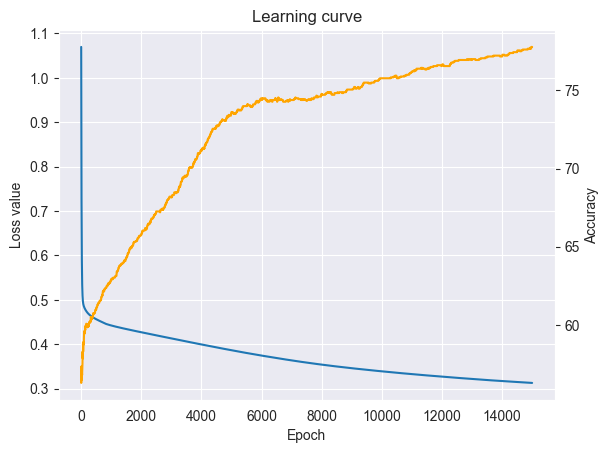

The final train accuracy: 77.8%
Test accuracy: 82.2%


In [18]:
model, metrics_history, X_test, Y_test, X_full, df = joblib.load("mlp_model_outputs.pkl")
fig, ax = plt.subplots()

ax.plot(range(len(metrics_history['loss'])), metrics_history['loss'])
ax.set_ylabel('Loss value')

ax2 = ax.twinx()
ax2.plot(range(len(metrics_history['accuracy'])), metrics_history['accuracy'], color='orange')
ax2.set_ylabel('Accuracy')

ax.set_xlabel('Epoch')

plt.title('Learning curve')
plt.grid()
plt.show()

print(f'The final train accuracy: {round(metrics_history["accuracy"][-1], 1)}%')
print(f'Test accuracy: {round(accuracy(model.decision_function(X_test), Y_test), 1)}%')



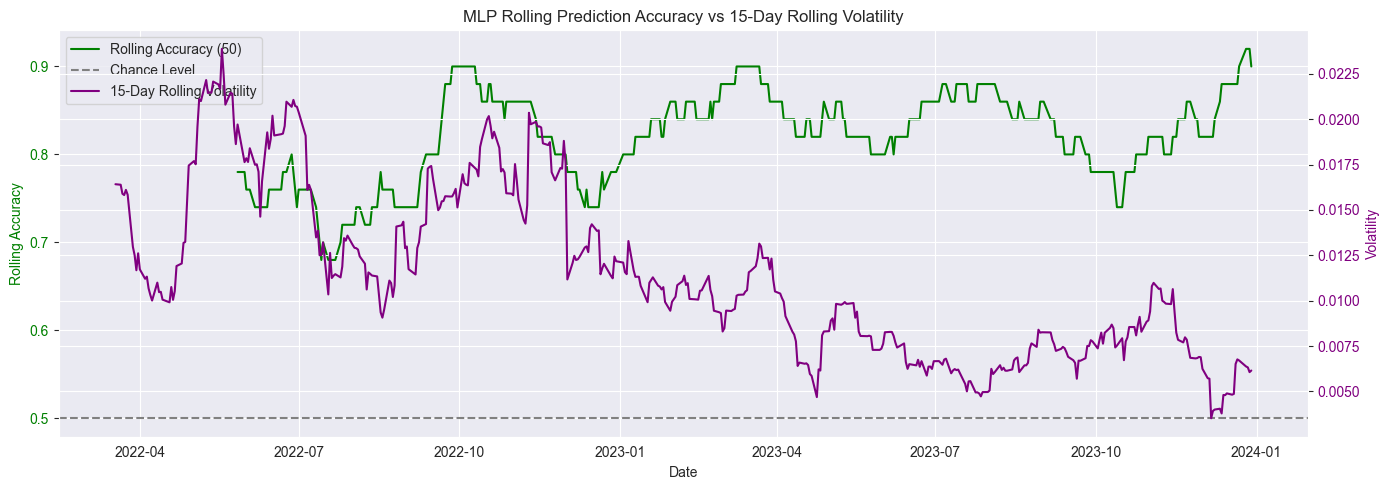

In [19]:
# Load model and data
model, metrics_history, X_test, Y_test, X_full, df = joblib.load("mlp_model_outputs.pkl")
Y_pred = model(X_test)

# Convert predictions to class labels
if Y_pred.ndim == 1 or Y_pred.shape[1] == 1:
    Y_pred_labels = (Y_pred > 0).astype(int).flatten()
    Y_true_labels = Y_test.flatten() if Y_test.ndim == 1 else Y_test.argmax(axis=1)
else:
    Y_pred_labels = np.argmax(Y_pred, axis=1)
    Y_true_labels = np.argmax(Y_test, axis=1)

# --- Rebuild full dataframe with technical indicators ---
df_copy = df.copy()
df_copy['Trend'] = df_copy['Close'].rolling(window=5).mean().shift(-1) > df_copy['Close']
df_copy['Target_01'] = np.where(df_copy['Trend'], 1, 0)
df_copy['Target_-1'] = np.where(df_copy['Trend'], 1, -1)


df_copy = compute_technical_indicators(df_copy, 3, 14)

df_copy = df_copy.reset_index()
df_copy.dropna(inplace=True)

# --- Build Accuracy DataFrame ---
test_dates = df_copy['Date'].iloc[-len(X_test):].values
results_df = pd.DataFrame({
    'Date': test_dates,
    'True': Y_true_labels,
    'Predicted': Y_pred_labels
})
results_df['Correct'] = results_df['True'] == results_df['Predicted']
results_df['Rolling_Accuracy'] = results_df['Correct'].rolling(window=50).mean()

# --- Calculate Volatility ---
df_copy['Daily_Return'] = df_copy['Close'].pct_change()
df_copy['Volatility_15d'] = df_copy['Daily_Return'].rolling(window=15).std()

# Align with test set
vol_series = df_copy['Volatility_15d'].iloc[-len(X_full):].values
date_series = df_copy['Date'].iloc[-len(X_full):].values
split_idx = int(len(X_full) * 0.8)
vol_test = vol_series[split_idx:]
vol_dates = date_series[split_idx:]

# --- Combined Plot ---
fig, ax1 = plt.subplots(figsize=(14, 5))

# Accuracy
ax1.plot(results_df['Date'], results_df['Rolling_Accuracy'], color='green', label='Rolling Accuracy (50)')
ax1.axhline(0.5, color='gray', linestyle='--', label='Chance Level')
ax1.set_ylabel('Rolling Accuracy', color='green')
ax1.tick_params(axis='y', labelcolor='green')

# Volatility
ax2 = ax1.twinx()
ax2.plot(vol_dates, vol_test, color='purple', label='15-Day Rolling Volatility')
ax2.set_ylabel('Volatility', color='purple')
ax2.tick_params(axis='y', labelcolor='purple')

# Title and axes
plt.title('MLP Rolling Prediction Accuracy vs 15-Day Rolling Volatility')
ax1.set_xlabel('Date')
plt.xticks(rotation=45)
ax1.grid(True)
fig.tight_layout()

# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.show()


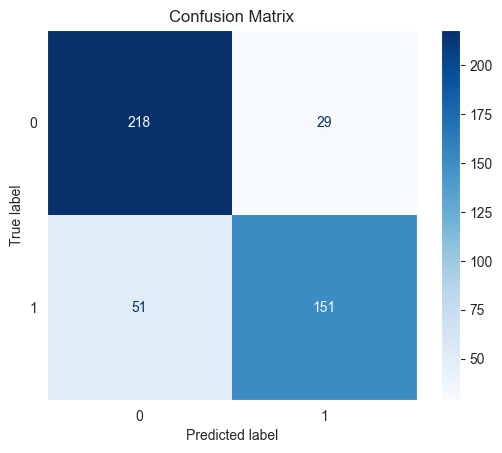

In [20]:
model, metrics_history, X_test, Y_test, X_full, df = joblib.load("mlp_model_outputs.pkl")
Y_pred = model(X_test)
# Convert predicted outputs to class labels
if Y_pred.ndim == 1 or Y_pred.shape[1] == 1:
    Y_pred_labels = (Y_pred > 0).astype(int).flatten()
    Y_true_labels = Y_test.flatten() if Y_test.ndim == 1 else Y_test.argmax(axis=1)
else:
    # Multiclass (e.g. shape [n_samples, 2])
    Y_pred_labels = np.argmax(Y_pred, axis=1)
    Y_true_labels = np.argmax(Y_test, axis=1)
# Compute and display the confusion matrix
cm = confusion_matrix(Y_true_labels, Y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()

### Baseline Model using autoregressive model and lagged returns

In [21]:
X, Y, X_train, Y_train, X_test, Y_test = return_data(df,target_type='Target_01',train_frac=.8,features = 'lagged')
X = min_max(X)
X_train = min_max(X_train)
X_test = min_max(X_test)
w = [0] * X.shape[1]
b = 0
optimizer = GDOptimizer(learning_rate=1e-2)

accuracy_lag = lambda y_true, y_pred: binary_accuracy(y_true, y_pred, class_labels=[0, 1])
metrics_dict = {'accuracy': accuracy_lag, 'MSE': mean_squared_error}

model = LinearRegression(w, b, optimizer)

metrics_history = model.fit(
    X_train, Y_train,
    num_epochs=20000,
    batch_size=len(X_train),
    compute_metrics=True,
    metrics_dict=metrics_dict
)

joblib.dump((model, metrics_history, X_test, Y_test, X, df), "lag_model_outputs.pkl")

['lag_model_outputs.pkl']

Final train accuracy (baseline): 67.00%
Test accuracy (baseline): 71.68%


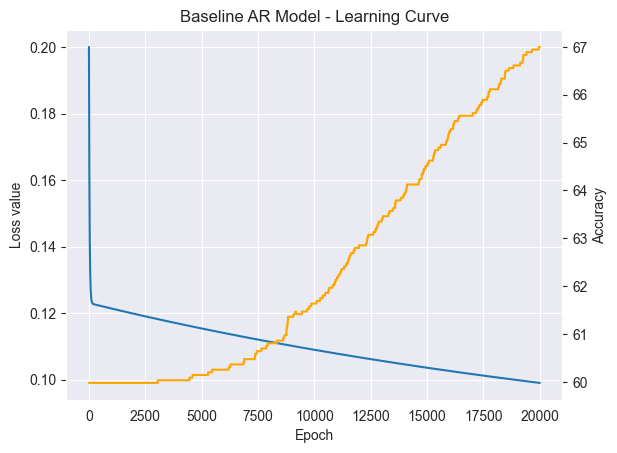

In [22]:
# Plot metrics
model, metrics_history, X_test, Y_test, X_full, df = joblib.load("lag_model_outputs.pkl")
fig, ax = plt.subplots()
ax.plot(metrics_history['MSE'], label='MSE')
ax.set_ylabel('Loss value')
ax.set_xlabel('Epoch')
ax2 = ax.twinx()
ax2.plot(metrics_history['accuracy'], color='orange', label='Accuracy')
ax2.set_ylabel('Accuracy')
plt.title('Baseline AR Model - Learning Curve')
plt.grid()

# Final metrics
train_acc = metrics_history["accuracy"][-1]
test_acc = accuracy_lag(model.decision_function(X_test), Y_test)

print(f'Final train accuracy (baseline): {train_acc :.2f}%')
print(f'Test accuracy (baseline): {test_acc :.2f}%')

plt.show()

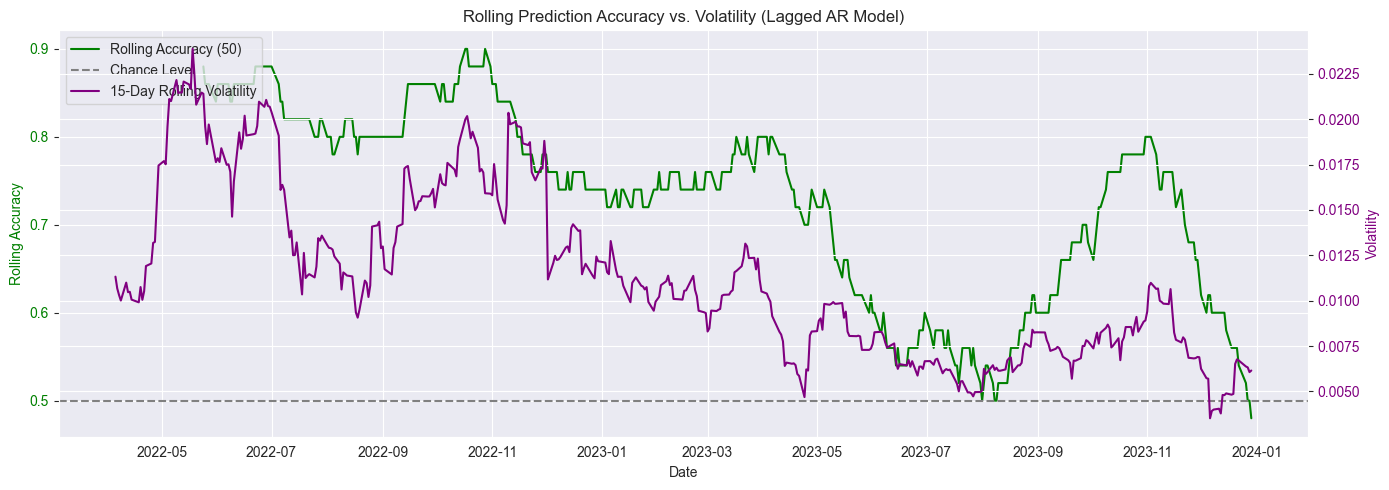

In [23]:
# Load model and data
model_regression, metrics_history, X_test, Y_test, X_full, df = joblib.load("lag_model_outputs.pkl")

# --- Preprocess Y ---
Y_true = Y_test.flatten() if Y_test.ndim > 1 else Y_test
Y_pred_raw = model_regression(X_test)
Y_pred = (Y_pred_raw > 0.5).astype(int).flatten()

# --- Prepare df_copy with indicators and trend ---
df_copy = df.copy()
df_copy['Trend'] = df_copy['Close'].rolling(window=5).mean().shift(-1) > df_copy['Close']
df_copy['Target_01'] = np.where(df_copy['Trend'], 1, 0)
df_copy['Target_-1'] = np.where(df_copy['Trend'], 1, -1)


df_copy = compute_technical_indicators(df_copy, 3, 14)

df_copy = df_copy.reset_index()
df_copy.dropna(inplace=True)

# --- Build accuracy DataFrame ---
test_dates = df_copy['Date'].iloc[-len(X_test):].values
results_df = pd.DataFrame({
    'Date': test_dates,
    'True': Y_true,
    'Predicted': Y_pred
})
results_df['Correct'] = results_df['True'] == results_df['Predicted']
results_df['Rolling_Accuracy'] = results_df['Correct'].rolling(window=50).mean()

# --- Compute volatility ---
df_copy['Daily_Return'] = df_copy['Close'].pct_change()
df_copy['Volatility_15d'] = df_copy['Daily_Return'].rolling(window=15).std()

# Align volatility to X_full and test period
vol_series = df_copy['Volatility_15d'].iloc[-len(X_full):].values
date_series = df_copy['Date'].iloc[-len(X_full):].values
split_idx = int(len(X_full) * 0.8)
vol_test = vol_series[split_idx:]
vol_dates = date_series[split_idx:]

# --- Combined Plot: Accuracy + Volatility ---
fig, ax1 = plt.subplots(figsize=(14, 5))

# Rolling Accuracy
ax1.plot(results_df['Date'], results_df['Rolling_Accuracy'], color='green', label='Rolling Accuracy (50)')
ax1.axhline(0.5, color='gray', linestyle='--', label='Chance Level')
ax1.set_ylabel('Rolling Accuracy', color='green')
ax1.tick_params(axis='y', labelcolor='green')

# Volatility (secondary y-axis)
ax2 = ax1.twinx()
ax2.plot(vol_dates, vol_test, color='purple', label='15-Day Rolling Volatility')
ax2.set_ylabel('Volatility', color='purple')
ax2.tick_params(axis='y', labelcolor='purple')

# Labels and legend
plt.title('Rolling Prediction Accuracy vs. Volatility (Lagged AR Model)')
ax1.set_xlabel('Date')
plt.xticks(rotation=45)
ax1.grid(True)
fig.tight_layout()

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.show()


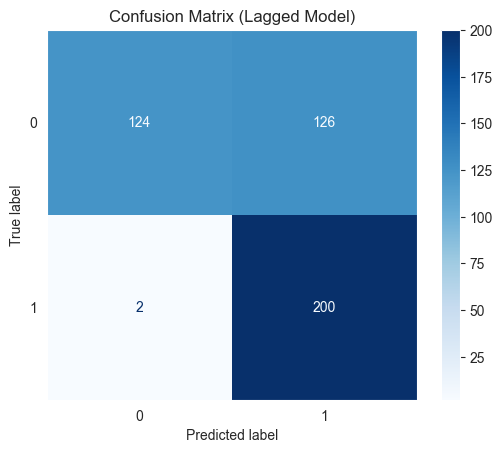

In [24]:
model_regression, metrics_history, X_test, Y_test, X_full, df = joblib.load("lag_model_outputs.pkl")

# Get raw predictions (continuous values)
y_pred_raw = model_regression(X_test)

# Convert raw predictions to binary class labels by thresholding at 0.5
y_pred_labels = (y_pred_raw > 0.5).astype(int).flatten()

# Flatten true labels if needed
y_true = Y_test.flatten() if Y_test.ndim > 1 else Y_test

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix (Lagged Model)')
plt.grid(False)
plt.show()

## Transferability 

In [29]:
df_transferability = fetch_data('AMZN', '2015-01-01', '2023-12-31')

model, metrics_history, X_test_mlp, Y_test_mlp, X_full_mlp, df_model = joblib.load("mlp_model_outputs.pkl")

X, Y, X_train, Y_train, X_test, Y_test = return_data(df_transferability,target_type='Target_-1',train_frac=.8)
X = min_max(X)
X_train = min_max(X_train)
X_test = min_max(X_test)
Y, Y_train, Y_test = labels_encoding(Y), labels_encoding(Y_train), labels_encoding(Y_test)

test_acc_tsla = round(accuracy(model.decision_function(X), Y),1)


print(f'Test accuracy : {test_acc_tsla :.2f}%')

/var/folders/pz/bkvmpwns7mgcx9s_bqb2lbyc0000gn/T/ipykernel_1982/1762355872.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start, end)
[*********************100%***********************]  1 of 1 completed


Test accuracy : 76.60%


# Daily Return Analysis and Trading Strategies

## RBF SVM

Model Training

In [6]:
data = fetch_data('SPY', '2015-01-01', '2025-12-31')
train_frac = 0.8
X, Y, X_train, Y_train, X_test, Y_test, data = return_data_daily_return(data, target_type='Target_Sign', train_frac=train_frac, features='whole')
X = standardize(X)
X_train = standardize(X_train)
X_test = standardize(X_test)


C:\Users\Micha\AppData\Local\Temp\ipykernel_21108\1091297748.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start, end)
[*********************100%***********************]  1 of 1 completed


In [7]:
rbf_svm = BinaryKernelSVM(kernel='rbf',sigma = 0.3)
metrics_history = rbf_svm.fit(X_train,Y_train)
binary_acc = binary_accuracy(rbf_svm(X_train), Y_train)

In [ ]:
y_pred_test = rbf_svm(X_test)
test_acc = binary_accuracy(y_pred_test, Y_test)
print("Test Accuracy:", test_acc)



Test Accuracy: 58.0952380952381


Trading Strategy with RBF SVM

In [ ]:
split_idx = int(round(train_frac * len(data)))
test_indices = data.index[split_idx:]

data['rbf_svm_pred'] = np.nan
data.loc[test_indices, 'rbf_svm_pred'] = y_pred_test
data['rbf_svm_pred'] = data['rbf_svm_pred'].shift(1)
data.dropna(inplace=True)
print("Number of -1 predictions:", (data['rbf_svm_pred'] == -1).sum())
print("Number of 1 predictions:", (data['rbf_svm_pred'] == 1).sum())

Number of -1 predictions: 20
Number of 1 predictions: 504


In [ ]:
data['strategy_return'] = data['Daily_Return'] * data['rbf_svm_pred']
data['cumulative_strategy'] = (1 + data['strategy_return']).cumprod()
data['cumulative_asset'] = (1 + data['Daily_Return']).cumprod()
print("strategy return is", data['cumulative_strategy'].iloc[-1])
print("asset return is", data['cumulative_asset'].iloc[-1])


strategy return is 1.4723707179472239
asset return is 1.5056197528566273


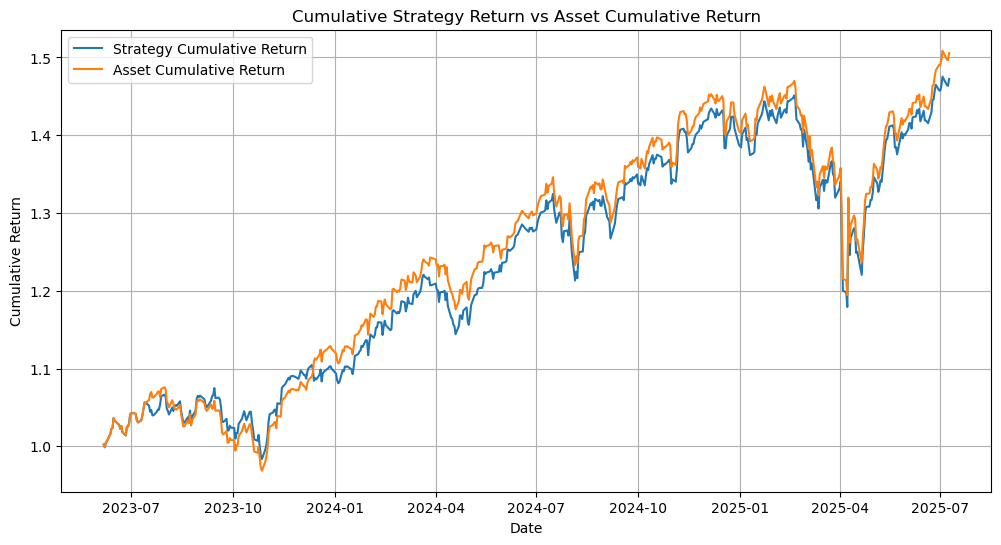

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['cumulative_strategy'], label='Strategy Cumulative Return')
plt.plot(data['Date'], data['cumulative_asset'], label='Asset Cumulative Return')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Strategy Return vs Asset Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

Reuse of the trained rbf svm model based on SPY and implement it on TSLA

In [8]:
data = fetch_data('TSLA', '2015-01-01', '2025-12-31')
train_frac = 0.8
X, Y, X_train, Y_train, X_test, Y_test, data = return_data_daily_return(data, target_type='Target_Sign', train_frac=train_frac, features='whole')
X = standardize(X)
X_train = standardize(X_train)
X_test = standardize(X_test)

C:\Users\Micha\AppData\Local\Temp\ipykernel_21108\1091297748.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start, end)
[*********************100%***********************]  1 of 1 completed


In [9]:
y_pred = rbf_svm(X)
test_acc = binary_accuracy(y_pred, Y)
print("Test Accuracy:", test_acc)

Test Accuracy: 52.19047619047619


In [10]:
y_pred_test = rbf_svm(X_test)
split_idx = int(round(train_frac * len(data)))
test_indices = data.index[split_idx:]
data['rbf_svm_pred'] = np.nan
data.loc[test_indices, 'rbf_svm_pred'] = y_pred_test
data['rbf_svm_pred'] = data['rbf_svm_pred'].shift(1)
data.dropna(inplace=True)
print("Number of -1 predictions:", (data['rbf_svm_pred'] == -1).sum())
print("Number of 1 predictions:", (data['rbf_svm_pred'] == 1).sum())

Number of -1 predictions: 8
Number of 1 predictions: 516


In [11]:
data['strategy_return'] = data['Daily_Return'] * data['rbf_svm_pred']
data['cumulative_strategy'] = (1 + data['strategy_return']).cumprod()
data['cumulative_asset'] = (1 + data['Daily_Return']).cumprod()
print("strategy return is", data['cumulative_strategy'].iloc[-1])
print("asset return is", data['cumulative_asset'].iloc[-1])

strategy return is 1.1485037965043445
asset return is 1.3596801803820109


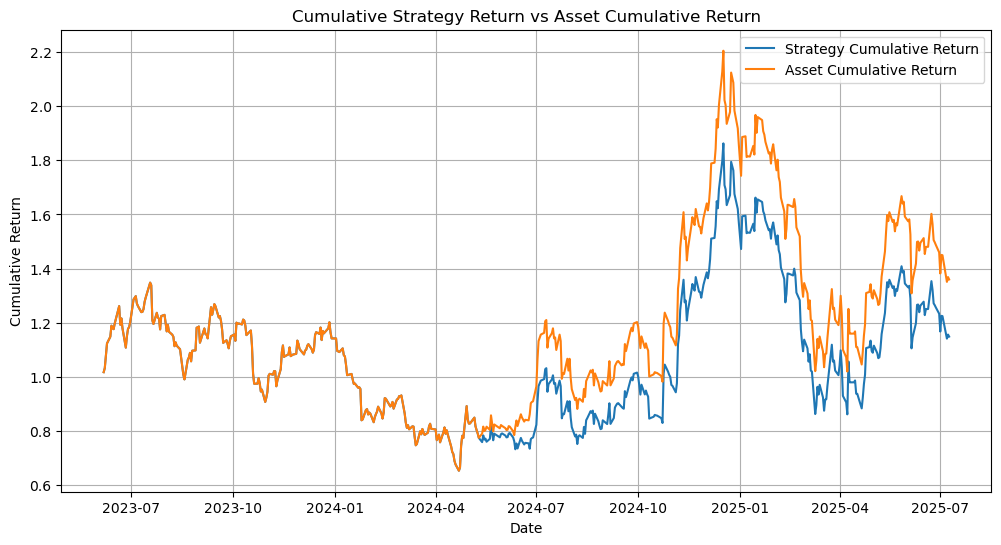

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['cumulative_strategy'], label='Strategy Cumulative Return')
plt.plot(data['Date'], data['cumulative_asset'], label='Asset Cumulative Return')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Strategy Return vs Asset Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

Logistic Regression

In [22]:
data = fetch_data('SPY', '2015-01-01', '2025-12-31')
train_frac = 0.8
X, Y, X_train, Y_train, X_test, Y_test, data = return_data_daily_return(data, target_type='Target_Sign_01', train_frac=train_frac, features='whole')
X = standardize(X)
X_train = standardize(X_train)
X_test = standardize(X_test)

C:\Users\Micha\AppData\Local\Temp\ipykernel_21108\1091297748.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start, end)
[*********************100%***********************]  1 of 1 completed


In [23]:
w = [0]*X.shape[1]
b = 0
optimizer = GDOptimizer(learning_rate=1e-4)

metrics_dict = {"accuracy": lambda y_pred, y_true: binary_accuracy(y_pred, y_true, class_labels=[0, 1]), 
                "loss": lambda y_pred, y_true: cross_entropy(y_pred, y_true)}
logistic_regression = LogisticRegression(w, b, optimizer)
metrics_history = logistic_regression.fit(X_train, Y_train, num_epochs=50000, batch_size=len(X_train), compute_metrics=True, metrics_dict=metrics_dict)

In [24]:
y_pred_test = logistic_regression(X_test)
test_acc = binary_accuracy(y_pred_test, Y_test, class_labels=[0, 1])
print("Test Accuracy:", test_acc)

Test Accuracy: 57.904761904761905


Trading Strategy with Logistic Regression

In [25]:
split_idx = int(round(train_frac * len(data)))
test_indices = data.index[split_idx:]
data['logistic_pred'] = np.nan
data.loc[test_indices, 'logistic_pred'] = y_pred_test
data['logistic_pred'] = data['logistic_pred'].shift(1)
data.dropna(inplace=True)
data['logistic_pred'].replace(0, -1, inplace=True)
print("Number of -1 predictions:", (data['logistic_pred'] == -1).sum())
print("Number of 1 predictions:", (data['logistic_pred'] == 1).sum())

Number of -1 predictions: 18
Number of 1 predictions: 506


C:\Users\Micha\AppData\Local\Temp\ipykernel_21108\2467822625.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['logistic_pred'].replace(0, -1, inplace=True)


In [26]:
data['strategy_return'] = data['Daily_Return'] * data['logistic_pred']
data['cumulative_strategy'] = (1 + data['strategy_return']).cumprod()
data['cumulative_asset'] = (1 + data['Daily_Return']).cumprod()
print("strategy return is", data['cumulative_strategy'].iloc[-1])
print("asset return is", data['cumulative_asset'].iloc[-1])

strategy return is 1.4602304553795684
asset return is 1.5064983970566523


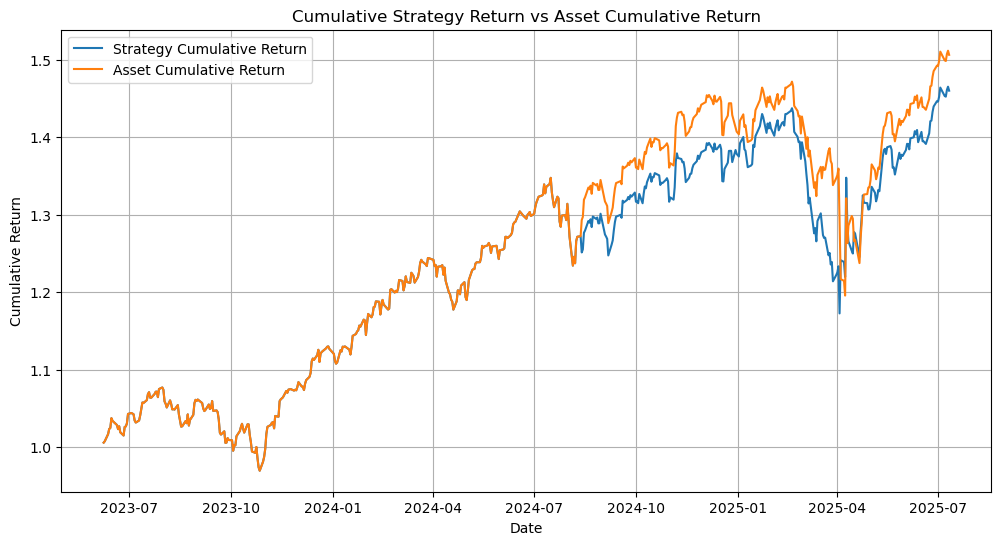

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['cumulative_strategy'], label='Strategy Cumulative Return')
plt.plot(data['Date'], data['cumulative_asset'], label='Asset Cumulative Return')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Strategy Return vs Asset Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

Reuse of the trained Logistic model based on SPY and implement it on TSLA

In [40]:
data = fetch_data('TSLA', '2015-01-01', '2025-12-31')
train_frac = 0.8
X, Y, X_train, Y_train, X_test, Y_test, data = return_data_daily_return(data, target_type='Target_Sign', train_frac=train_frac, features='whole')
X = standardize(X)
X_train = standardize(X_train)
X_test = standardize(X_test)

C:\Users\Micha\AppData\Local\Temp\ipykernel_21108\1091297748.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start, end)
[*********************100%***********************]  1 of 1 completed


In [42]:
y_pred = logistic_regression(X)
test_acc = binary_accuracy(y_pred, Y, class_labels=[0, 1])
print("Test Accuracy:", test_acc)

Test Accuracy: 49.523809523809526


In [37]:
y_pred_test = logistic_regression(X_test)
split_idx = int(round(train_frac * len(data)))
test_indices = data.index[split_idx:]
data['logistic_pred'] = np.nan
data.loc[test_indices, 'logistic_pred'] = y_pred_test
data['logistic_pred'] = data['logistic_pred'].shift(1)
data.dropna(inplace=True)
data['logistic_pred'].replace(0, -1, inplace=True)

C:\Users\Micha\AppData\Local\Temp\ipykernel_21108\430142682.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['logistic_pred'].replace(0, -1, inplace=True)


In [38]:
data['strategy_return'] = data['Daily_Return'] * data['logistic_pred']
data['cumulative_strategy'] = (1 + data['strategy_return']).cumprod()
data['cumulative_asset'] = (1 + data['Daily_Return']).cumprod()
print("strategy return is", data['cumulative_strategy'].iloc[-1])
print("asset return is", data['cumulative_asset'].iloc[-1])

strategy return is 1.121540620116246
asset return is 1.3596801803820109


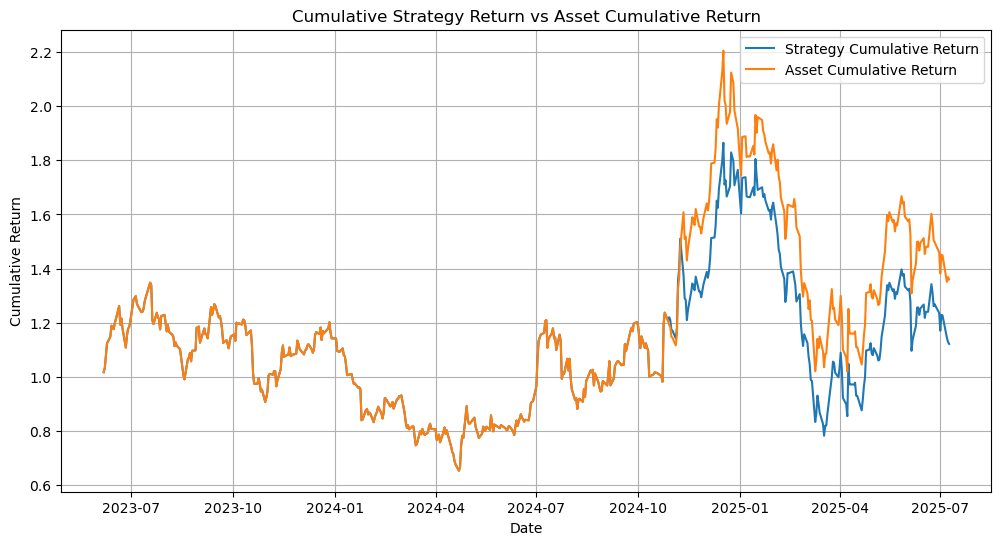

In [39]:
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['cumulative_strategy'], label='Strategy Cumulative Return')
plt.plot(data['Date'], data['cumulative_asset'], label='Asset Cumulative Return')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Strategy Return vs Asset Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()